In [1]:
from loss import DiceLoss, DoubleDiceLoss, ScaledDiceLoss, BoundaryDiceLoss, CombinedDiceBCELoss

In [26]:
import numpy as np
import torch


def generate_masks(intersection, union):
    # return None for invalid values
    if intersection > union:
        return None, None
    if intersection < 0 or union < 0 or intersection > 1 or union > 1:
        return None, None
    
    # Generate two 1d arrays of zeros of length 100
    mask1 = np.zeros(100)
    mask2 = np.zeros(100)
    
    # The intersection is the minimum that the two masks can have in common
    # Therefore, the first mask will have at least the 100 * intersection first elements set to 1
    mask1[:int(100 * intersection)] = 1
    
    # The union is the maximum that the two masks can have in common
    # Therefore, the second mask will have at most the 100 * union first elements set to 1
    mask2[:int(100 * union)] = 1
    
    return mask1.reshape(1, 1, 10, 10), mask2.reshape(1, 1, 10, 10)
    

def get_losses(intersection, union, loss_class, loss_class_kwargs):    
    # Initialize the loss
    criterion = loss_class(**loss_class_kwargs)
    
    # Initialize the list of loss values
    loss_values = []
    
    # Calculate the loss for each pair of intersection and union
    for i in intersection:
        row_union = []
        for u in union:
            # To be passed to the losses, we must create dummy tensors with shape (1, 1, H, W)
            # where H and W are the height and width of the image
            # The goal is generate two masks that have the desired intersection and union
            # The actual shape of the masks is not important as it is not used in the loss calculation
            mask1, mask2 = generate_masks(i, u)
            
            # Return nan if the masks are invalid
            if mask1 is None or mask2 is None:
                row_union.append(np.nan)
            else:
                # convert the masks to tensors
                mask1 = torch.tensor(mask1, dtype=torch.float32)
                mask2 = torch.tensor(mask2, dtype=torch.float32)
                
                # Calculate the loss for the pair of masks
                loss = criterion(mask1, mask2)
                row_union.append(loss.item())
                
        loss_values.append(row_union)
    
    return np.array(loss_values).T

In [27]:
import numpy as np
import matplotlib.pyplot as plt


def plot_loss(loss_class, loss_fn_kwargs, name):
    # Generate values for intersection and union
    intersection = np.linspace(0, 1, 100, endpoint=False)
    union = np.linspace(0, 1, 100, endpoint=False)
    
    # Generate the grid of intersection and union values
    intersection_grid, union_grid = np.meshgrid(intersection, union)
    
    # Calculate the loss values for each pair of intersection and union
    loss_values = get_losses(intersection, union, loss_class, loss_fn_kwargs)
    
    # Plot the 3D surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(intersection_grid, union_grid, loss_values, cmap='viridis')
    
    # Add labels and title
    ax.set_xlabel('Intersection')
    ax.set_ylabel('Union')
    ax.set_zlabel(name)
    ax.set_title(f'3D Plot of {name} for Varying Intersection and Union')
    
    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

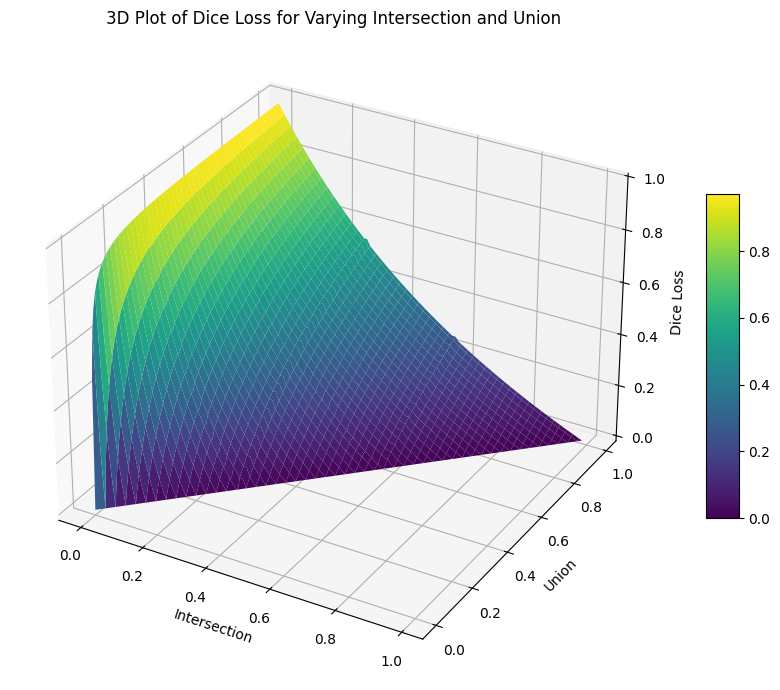

In [28]:
# Plot the Dice Loss
plot_loss(DiceLoss, {}, 'Dice Loss')

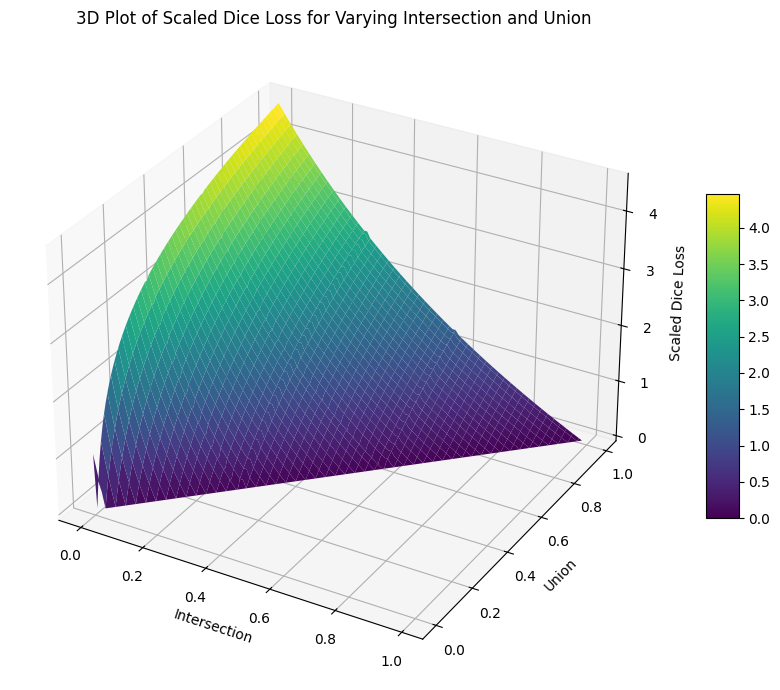

In [30]:
# Plot the Scaled Dice Loss
plot_loss(ScaledDiceLoss, {"threshold_zero_loss": 0}, 'Scaled Dice Loss')

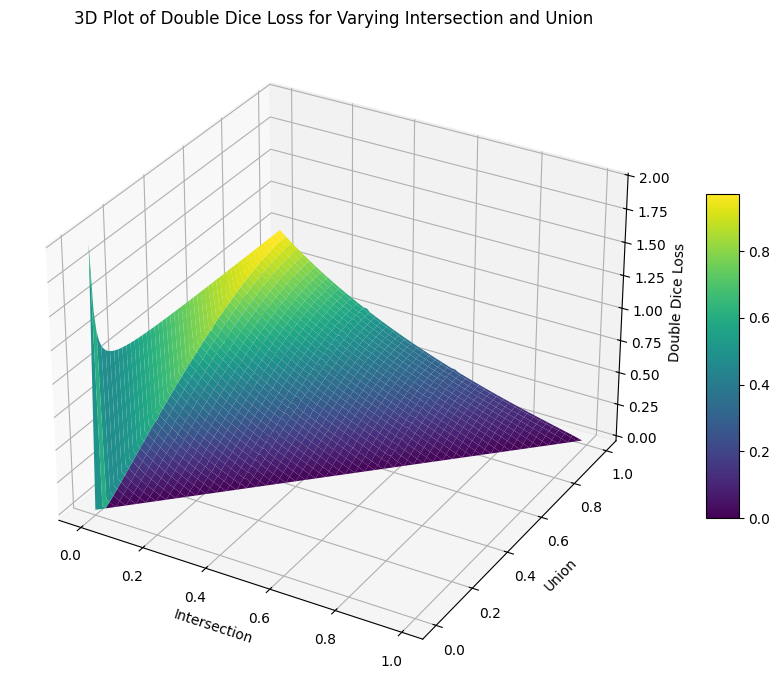

In [29]:
# Plot the Double Dice Loss
plot_loss(DoubleDiceLoss, {}, 'Double Dice Loss')

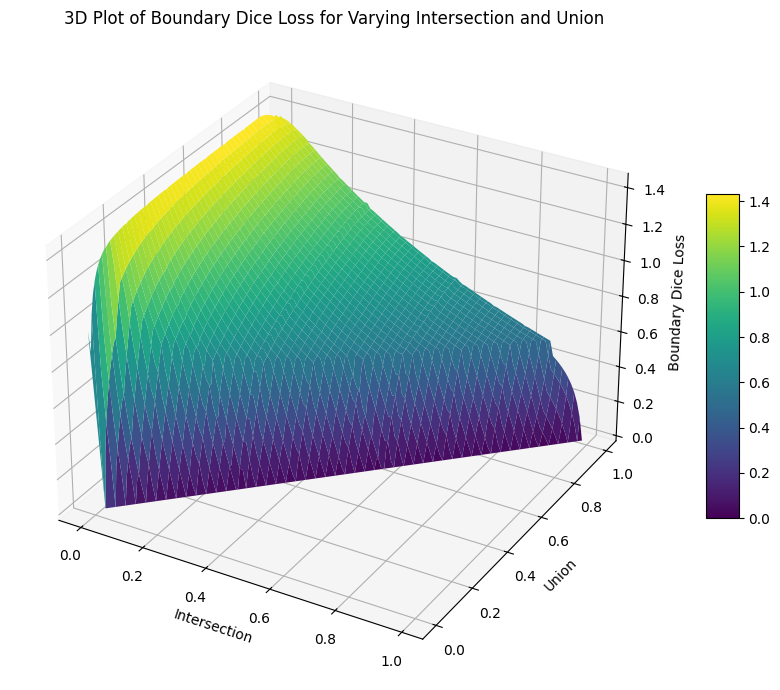

In [31]:
# Plot the Boundary Dice Loss
plot_loss(BoundaryDiceLoss, {"threshold_zero_loss": 0}, 'Boundary Dice Loss')

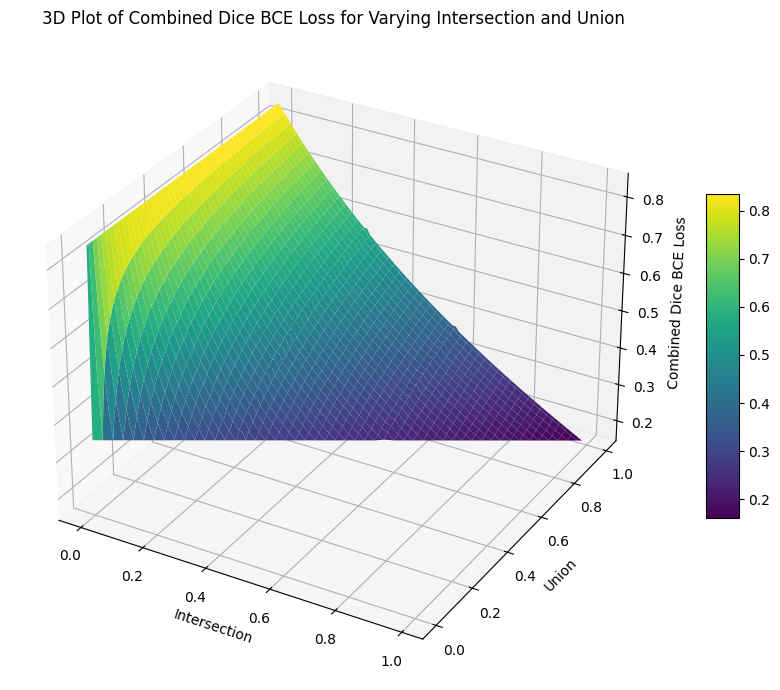

In [32]:
# Print the Combined Dice BCE Loss
plot_loss(CombinedDiceBCELoss, {}, 'Combined Dice BCE Loss')